In [1]:
import tensorflow as tf
import numpy as np
import os.path as osp
import matplotlib.pylab as plt
import six

import sys
sys.path.append('/home/davidxue/notebooks/tensorflow/cs233_hw4_2018/hw4_code')
print(sys.path)


from hw4_code.numpy_dataset import NumpyDataset
from hw4_code.cs233_point_auto_encoder import cs233PointAutoEncoder
from hw4_code.neural_net import Neural_Net_Conf
from hw4_code.encoders_decoders import encoder_with_convs_and_symmetry, decoder_with_fc_only
from hw4_code.in_out_utils import unpickle_data, pickle_data, create_dir


import os.path as osp 
from plt_utils import plot_2d_embedding_in_grid_greedy_way
from sklearn.manifold import TSNE

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['', '/opt/caffe/python', '/opt/caffe2/build', '/home/davidxue/notebooks/tensorflow/cs233_hw4_2018', '/anaconda/envs/py35/lib/python35.zip', '/anaconda/envs/py35/lib/python3.5', '/anaconda/envs/py35/lib/python3.5/plat-linux', '/anaconda/envs/py35/lib/python3.5/lib-dynload', '/anaconda/envs/py35/lib/python3.5/site-packages', '/anaconda/envs/py35/lib/python3.5/site-packages/Mako-1.0.7-py3.5.egg', '/anaconda/envs/py35/lib/python3.5/site-packages/xgboost-0.7-py3.5.egg', '/anaconda/envs/py35/lib/python3.5/site-packages/dlib-19.9.0-py3.5-linux-x86_64.egg', '/anaconda/envs/py35/lib/python3.5/site-packages/mxnet-1.0.0-py3.5.egg', '/anaconda/envs/py35/lib/python3.5/site-packages/torchvision-0.2.0-py3.5.egg', '/anaconda/envs/py35/lib/python3.5/site-packages/IPython/extensions', '/home/davidxue/.ipython', '/home/davidxue/notebooks/tensorflow/cs233_hw4_2018/hw4_code']


# Tensorflow pipeline code

In [2]:
# Students: If you run your code with Python3 instead of Python2 (like in Azzure) set python_2to3=True
python_2to3 = True


# Students: Default options for splits. Do NOT change.
split_loads = [0.75, 0.15, 0.10]
random_seed = 42
verbose = True
n_total_shapes = 1000

# Training options.
do_training = True
batch_size = 50        # Students: do NOT change this one.
held_out_step = 10
n_epochs = 400

# Loading DATA/employing train/val/test splits.
generator = unpickle_data('data/in/part_labeled_point_clouds.pkl', python_2to3)
hw4_data = six.next(generator)
sids = six.next(unpickle_data('data/in/randomized_ids.pkl', python_2to3))
hw4_data.part_masks = hw4_data.part_masks.astype(np.int32)

hw4_data = hw4_data.subsample(n_total_shapes, replace=False, seed=random_seed)
net_data = {}
for s in sids:
    idx = sids[s]
    net_data[s] = hw4_data.extract(idx)
test_data = net_data['test'].freeze()

In [6]:
tf.reset_default_graph()

In [7]:
# Define Configuration of the Point-AE.
pc_ae_conf = Neural_Net_Conf()

n_pc_per_model = net_data['train'].pcs.shape[-2]
bneck = 128

pc_ae_conf.encoder = encoder_with_convs_and_symmetry
pc_ae_conf.decoder = decoder_with_fc_only

pc_ae_conf.n_points = n_pc_per_model

pc_ae_conf.encoder_args = {'n_filters':5, 'filter_sizes':[32, 64, 64, 128, 128],
                          'verbose':True} # Students add your encoder's options.

pc_ae_conf.decoder_args = {'layer_sizes': [256, 256, n_pc_per_model * 3],                           
                           'verbose': True}

pc_ae_conf.learning_rate = 0.0009
pc_ae_conf.saver_max_to_keep = 1
pc_ae_conf.allow_gpu_growth = True


# Students: Will it predict part-segmentation too? If so, set to true. 
pc_ae_conf.use_parts = True
pc_ae_conf.n_parts = 4
pc_ae_conf.part_pred_with_one_layer = True


# How much is the relative importance of part-prediction vs. pc-reconstruction.
pc_ae_conf.part_weight = 0.005 #Students: leave this option unchanged for the (non-bonus) questions.

if pc_ae_conf.use_parts:
    if pc_ae_conf.part_pred_with_one_layer:
        pc_ae_conf.name = 'pc_aware_ae'
    else:
        pc_ae_conf.name = 'pc_aware_ae_bonus'
    n_losses = 2
else:
    pc_ae_conf.name = 'vanilla_ae'
    n_losses = 1

In [8]:
ae = cs233PointAutoEncoder(pc_ae_conf.name, pc_ae_conf)

Building Encoder
Building Decoder


In [9]:
if do_training:
    save_dir = create_dir(osp.join('data/out/Neural_nets', pc_ae_conf.name))    
    tf.set_random_seed(random_seed)
    np.random.seed(random_seed)
    with open(osp.join(save_dir, 'net_stats.txt'), 'w') as file_out:            
        train_loss, val_loss, test_loss = ae.train_model(net_data, n_epochs, batch_size, save_dir,\
                                                         held_out_step, fout=file_out)

Training epoch/loss/duration:  1 [  33.94328111 1391.40316569] 4.953371286392212
Training epoch/loss/duration:  2 [   6.04011056 1345.28666178] 4.48674201965332
Training epoch/loss/duration:  3 [   4.4474068  1316.87017415] 4.5430169105529785
Training epoch/loss/duration:  4 [   4.01665592 1291.13647461] 4.496519088745117
Training epoch/loss/duration:  5 [   3.86557803 1265.18828939] 4.529568195343018
Training epoch/loss/duration:  6 [   3.79048893 1237.78850098] 4.581768035888672
Training epoch/loss/duration:  7 [   3.69639761 1204.30036621] 4.514070510864258
Training epoch/loss/duration:  8 [   3.6493101 1159.4575765] 4.546817779541016
Training epoch/loss/duration:  9 [   3.58038885 1098.31611328] 4.594438076019287
Training epoch/loss/duration:  10 [   3.51787411 1020.8166097 ] 4.520156383514404
Val/Test epoch/loss: 10 [  3.60315514 983.90509033] [  3.82959938 988.38789876]
Training epoch/loss/duration:  11 [  3.4097867  931.19117432] 4.576975107192993
Training epoch/loss/duration:  

Training epoch/loss/duration:  95 [  1.05119727 273.74859009] 4.658466577529907
Training epoch/loss/duration:  96 [  1.06896105 274.12882894] 4.614769458770752
Training epoch/loss/duration:  97 [  1.05245181 272.4982076 ] 4.5994696617126465
Training epoch/loss/duration:  98 [  1.04940932 271.462677  ] 4.61181116104126
Training epoch/loss/duration:  99 [  1.02587862 270.5846639 ] 4.6144843101501465
Training epoch/loss/duration:  100 [  1.02469792 269.52288005] 4.6556291580200195
Val/Test epoch/loss: 100 [  1.38983309 268.11122894] [  1.44112277 307.07892863]
Training epoch/loss/duration:  101 [  1.02140982 268.49881795] 4.590184926986694
Training epoch/loss/duration:  102 [  1.02482111 268.38955688] 4.652920722961426
Training epoch/loss/duration:  103 [  1.00715152 267.39834798] 4.741726636886597
Training epoch/loss/duration:  104 [  1.01346464 266.7630188 ] 4.668270587921143
Training epoch/loss/duration:  105 [  1.02405858 266.09680888] 4.6101226806640625
Training epoch/loss/duration: 

Training epoch/loss/duration:  188 [  0.82344143 242.66384074] 4.604321002960205
Training epoch/loss/duration:  189 [  0.80634245 241.17224426] 4.6366589069366455
Training epoch/loss/duration:  190 [  0.81205502 241.11470642] 4.62714958190918
Val/Test epoch/loss: 190 [  1.31096482 253.33737946] [  1.36397386 277.37270101]
Training epoch/loss/duration:  191 [  0.79564376 240.97850342] 4.6261303424835205
Training epoch/loss/duration:  192 [  0.78331737 240.45736186] 4.7953619956970215
Training epoch/loss/duration:  193 [  0.79124922 240.47432251] 4.622222900390625
Training epoch/loss/duration:  194 [  0.77213624 240.76552226] 4.703435897827148
Training epoch/loss/duration:  195 [  0.77413199 239.961144  ] 4.63471531867981
Training epoch/loss/duration:  196 [  0.78812253 240.1025472 ] 4.61249852180481
Training epoch/loss/duration:  197 [  0.78588995 240.29499308] 4.601680755615234
Training epoch/loss/duration:  198 [  0.79925147 239.89322917] 4.592767715454102
Training epoch/loss/duration

Val/Test epoch/loss: 280 [  1.26894987 250.40329742] [  1.33142328 269.07084656]
Training epoch/loss/duration:  281 [  0.68836474 229.07300415] 4.586121559143066
Training epoch/loss/duration:  282 [  0.72467438 228.75653585] 4.659730672836304
Training epoch/loss/duration:  283 [  0.763035   228.81920675] 4.623546361923218
Training epoch/loss/duration:  284 [  0.69663262 228.77683105] 4.6550843715667725
Training epoch/loss/duration:  285 [  0.68115849 228.76876933] 4.642722845077515
Training epoch/loss/duration:  286 [  0.68061951 229.04731242] 4.661147117614746
Training epoch/loss/duration:  287 [  0.67234661 229.23657735] 4.629737615585327
Training epoch/loss/duration:  288 [  0.66999914 228.72581685] 4.62189245223999
Training epoch/loss/duration:  289 [  0.67387893 228.04072469] 4.679657220840454
Training epoch/loss/duration:  290 [  0.68527668 228.41403097] 4.62008261680603
Val/Test epoch/loss: 290 [  1.2835111  251.00093842] [  1.33668145 271.05042013]
Training epoch/loss/duration:

Training epoch/loss/duration:  373 [  0.62672821 221.50881144] 4.586974620819092
Training epoch/loss/duration:  374 [  0.61582077 221.39242757] 4.5870201587677
Training epoch/loss/duration:  375 [  0.61042237 222.36439107] 4.585545301437378
Training epoch/loss/duration:  376 [  0.6238356  221.79826864] 4.629644155502319
Training epoch/loss/duration:  377 [  0.62760499 221.28613892] 4.564809799194336
Training epoch/loss/duration:  378 [  0.61435231 221.8868276 ] 4.687070608139038
Training epoch/loss/duration:  379 [  0.63481346 221.67355957] 4.582481622695923
Training epoch/loss/duration:  380 [  0.63117901 221.04268799] 4.566487789154053
Val/Test epoch/loss: 380 [  1.27060556 251.30368805] [  1.32430108 266.09775798]
Training epoch/loss/duration:  381 [  0.62410945 222.16491089] 4.604033946990967
Training epoch/loss/duration:  382 [  0.62679083 221.32915649] 4.589884042739868
Training epoch/loss/duration:  383 [  0.64593273 221.71445211] 4.638929843902588
Training epoch/loss/duration: 

In [10]:
!ls data/out/Neural_nets/pc_aware_ae
save_dir = osp.join('data/out/Neural_nets', pc_ae_conf.name)

checkpoint			     models.ckpt-290.data-00000-of-00001
latent_codes.npz		     models.ckpt-290.index
models.ckpt-280.data-00000-of-00001  models.ckpt-290.meta
models.ckpt-280.index		     net_stats.txt
models.ckpt-280.meta


In [12]:
# Load model on optimal (per validation) epoch.
if do_training:
    if pc_ae_conf.use_parts:
        total_val_loss = val_loss[:,0]+ae.config.part_weight*val_loss[:,1]
    else:
        total_val_loss = val_loss

    epoch_to_restore = (1+np.argmin(total_val_loss))*held_out_step # Student 
    
ae.restore_model(save_dir, epoch_to_restore, verbose=True)



INFO:tensorflow:Restoring parameters from data/out/Neural_nets/pc_aware_ae/models.ckpt-280
Model restored in epoch 280.


# Plot of losses

## With parts

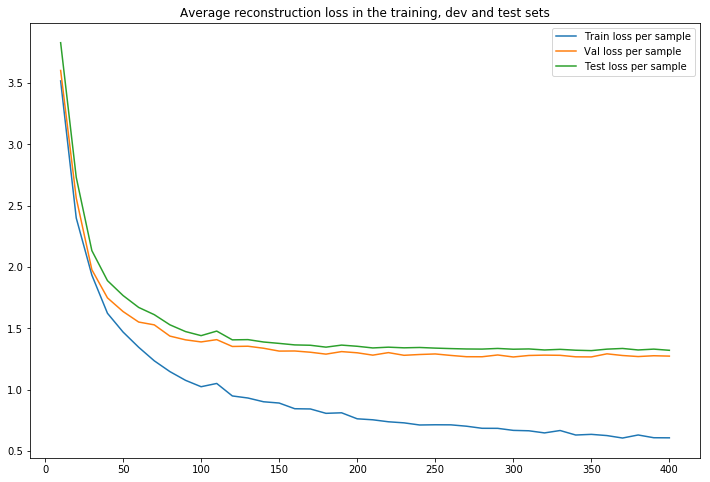

In [13]:
plt.figure(figsize=(12,8))

epochs_plotted = held_out_step*np.arange(1,int(n_epochs/held_out_step)+1)
train_loss_10_epoch = train_loss[epochs_plotted-1]

plt.plot(epochs_plotted,train_loss_10_epoch[:,0], label='Train loss per sample')
plt.plot(epochs_plotted,val_loss[:,0], label='Val loss per sample')
plt.plot(epochs_plotted,test_loss[:,0], label='Test loss per sample')


plt.title('Average reconstruction loss in the training, dev and test sets')
plt.legend()
plt.show()


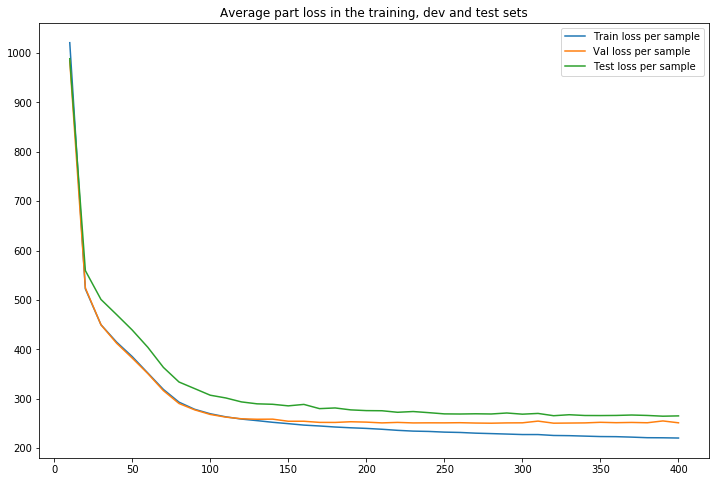

In [14]:
plt.figure(figsize=(12,8))

epochs_plotted = held_out_step*np.arange(1,int(n_epochs/held_out_step)+1)
train_loss_10_epoch = train_loss[epochs_plotted-1]

plt.plot(epochs_plotted,train_loss_10_epoch[:,1], label='Train loss per sample')
plt.plot(epochs_plotted,val_loss[:,1], label='Val loss per sample')
plt.plot(epochs_plotted,test_loss[:,1], label='Test loss per sample')


plt.title('Average part loss in the training, dev and test sets')
plt.legend()
plt.show()



## Without parts

In [3]:
plt.figure(figsize=(12,8))

epochs_plotted = held_out_step*np.arange(1,int(n_epochs/held_out_step)+1)
train_loss_10_epoch = train_loss[epochs_plotted-1]

plt.plot(epochs_plotted,train_loss_10_epoch, label='Train loss per sample')
plt.plot(epochs_plotted,val_loss, label='Val loss per sample')
plt.plot(epochs_plotted,test_loss, label='Test loss per sample')


plt.title('Average reconstruction loss in the training, dev and test sets')
plt.legend()
plt.show()

NameError: name 'train_loss' is not defined

# Accuracy (with parts) and reconstruction

In [15]:
feed = ae.prepare_feed(test_data, test_data.n_examples)
if pc_ae_conf.use_parts:
    pred, label, accuracy = ae.sess.run([tf.cast(tf.argmax(ae.part_pred, -1),tf.int32),ae.part_mask, ae.acc_by_parts],
                                        feed_dict=feed)
    print("The accuracy on the test set is {}".format(accuracy))

The accuracy on the test set is 0.9070637822151184


In [16]:
test_names = test_data.model_names
feed = ae.prepare_feed(test_data, test_data.n_examples)

l_codes = ae.sess.run(ae.z, feed_dict=feed) # Students: compute this.
np.savez(osp.join(save_dir, 'latent_codes'), l_codes=l_codes, test_names=test_names)

In [17]:
# Students: Save-plot reconstructions.
n_plots = 5
in_pc = test_data.pcs[:n_plots]
in_names = test_data.model_names[:n_plots]
in_masks = test_data.part_masks[:n_plots]

recon_pc = ae.sess.run(ae.pc_reconstr, feed_dict=feed)

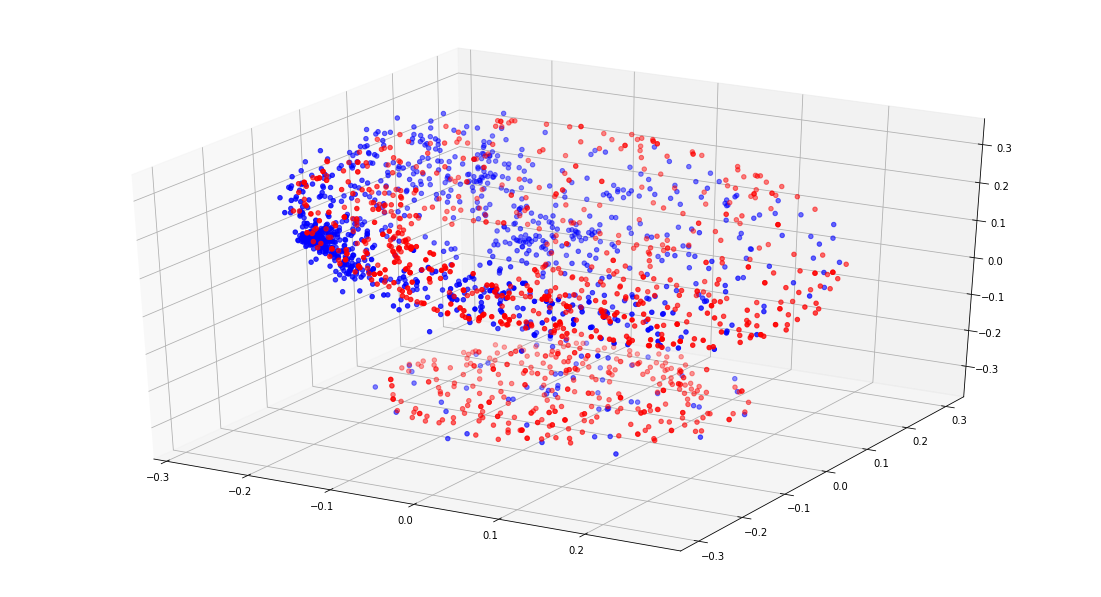

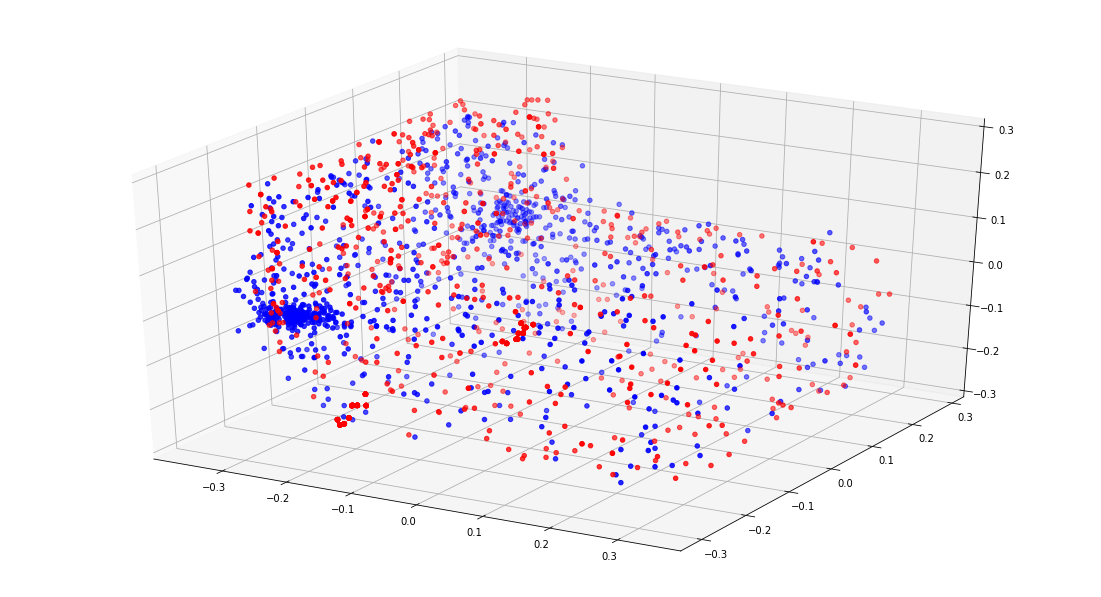

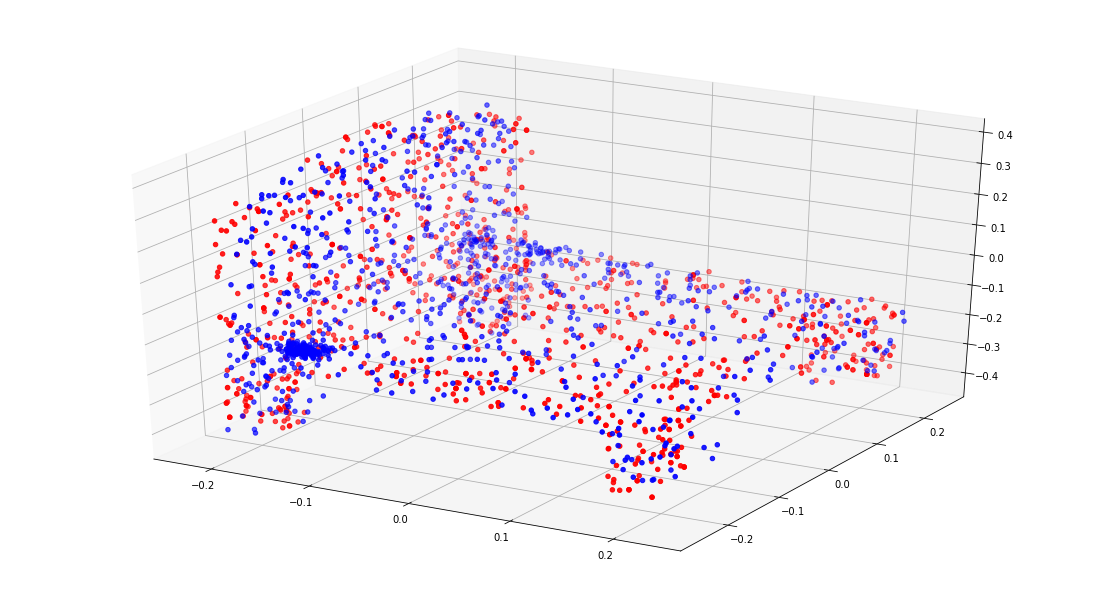

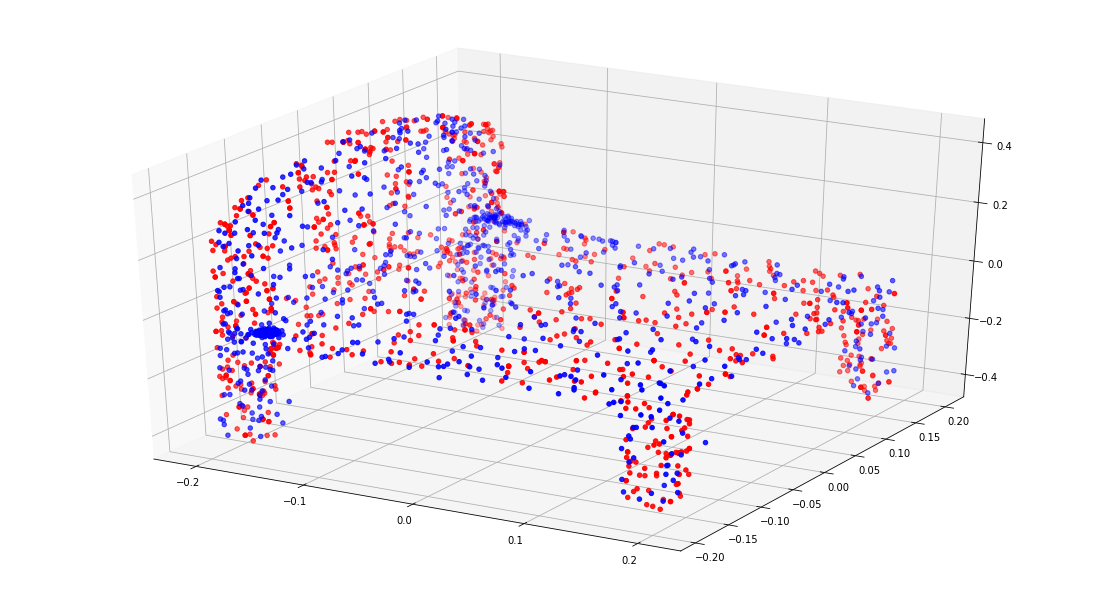

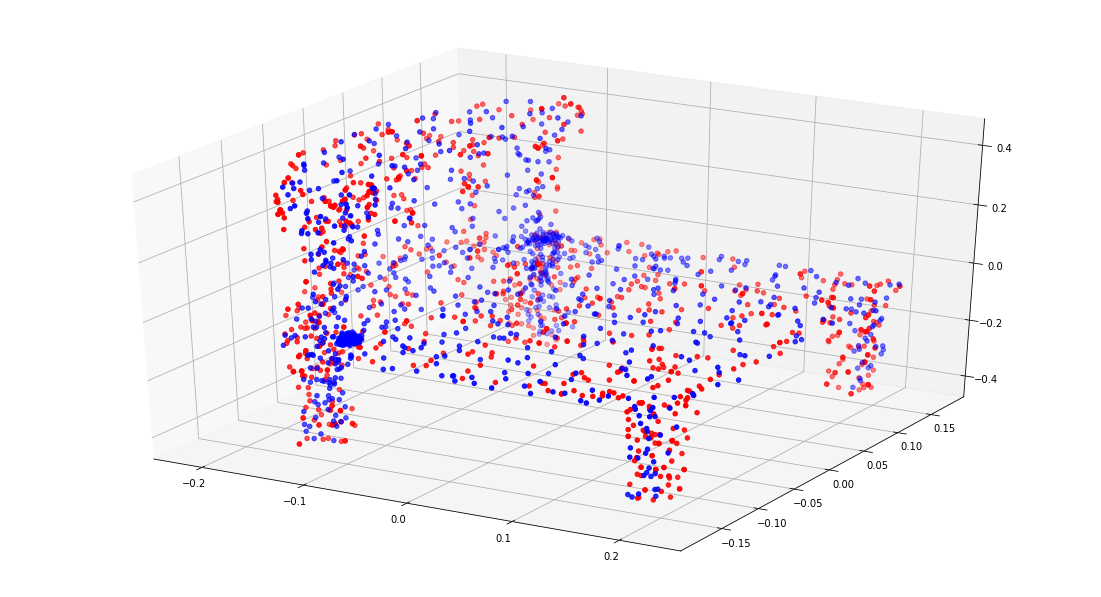

In [18]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors

for n_th_shape in range(5):
    fig = plt.figure(figsize=(15,8))

    ax = Axes3D(fig)

    ax.scatter(in_pc[n_th_shape,:,0], in_pc[n_th_shape,:,1], in_pc[n_th_shape,:,2], c='red')
    ax.scatter(recon_pc[n_th_shape,:,0], recon_pc[n_th_shape,:,1], recon_pc[n_th_shape,:,2], c='blue')

    plt.show()

## Prediction of parts

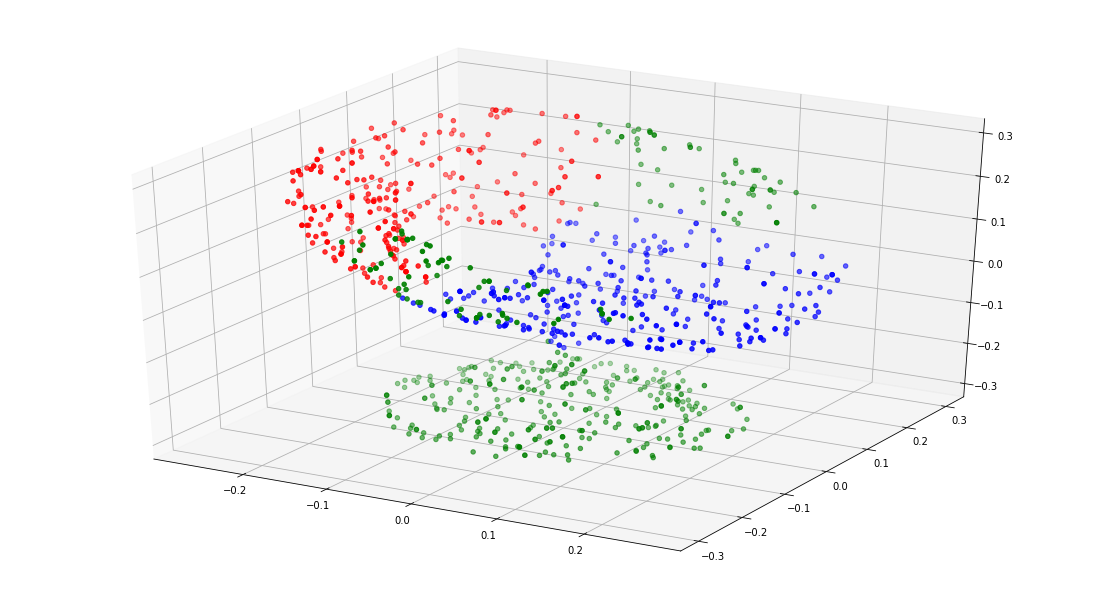

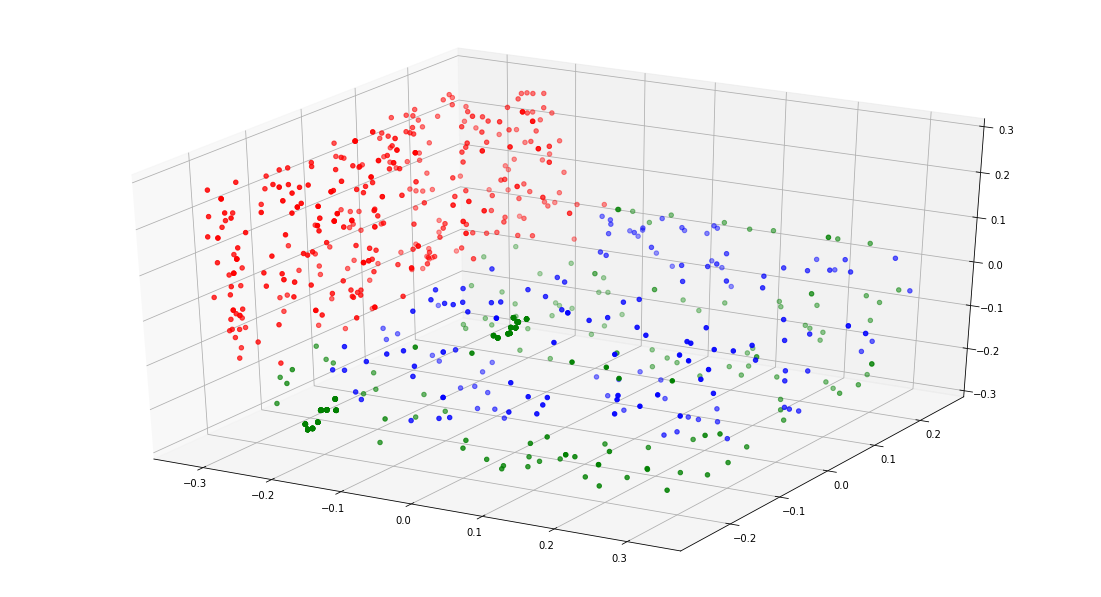

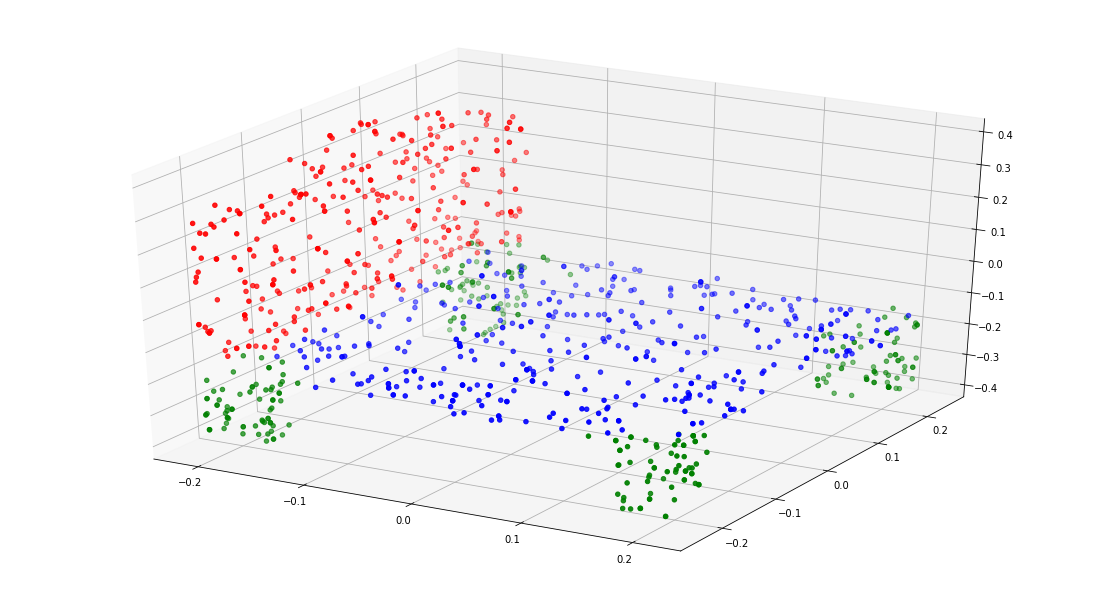

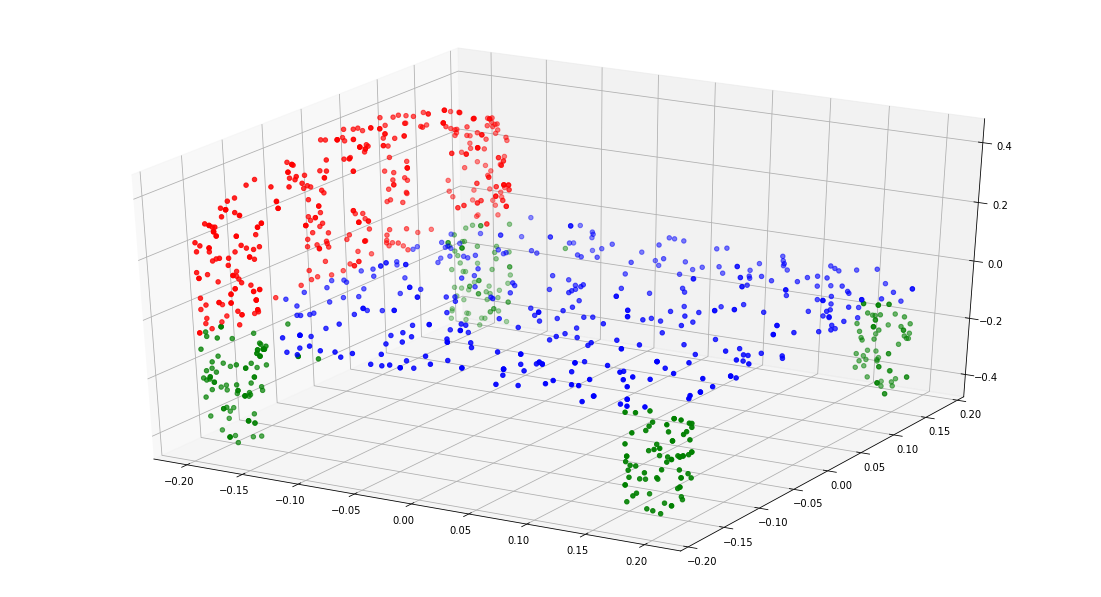

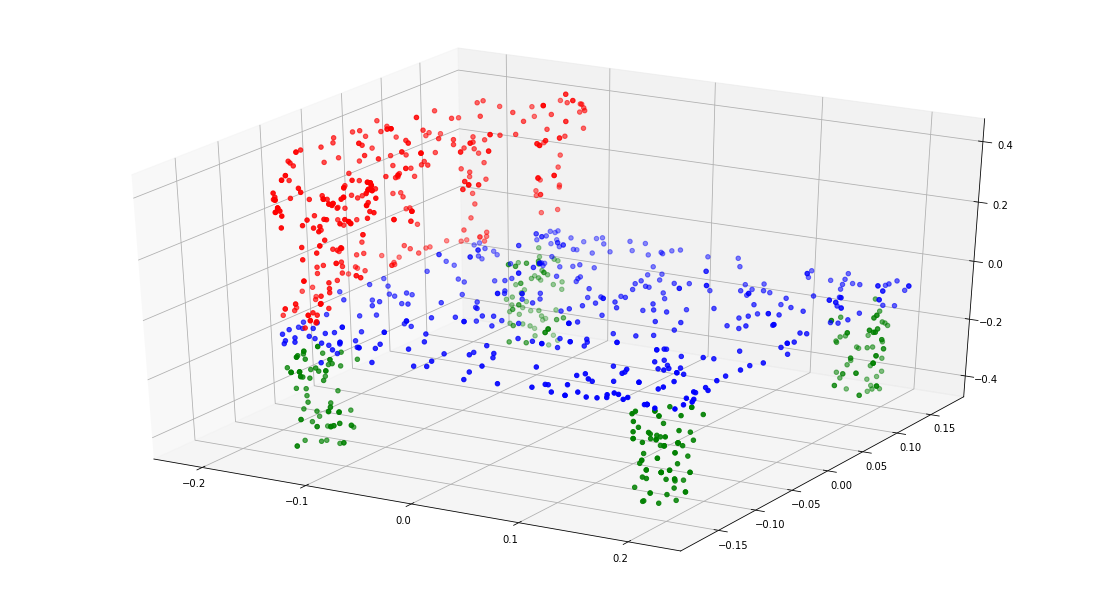

In [21]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors as mcolors

colors = ['red', 'blue', 'green', 'yellow']
levels = [0, 1, 2, 3]
cmap, norm = mcolors.from_levels_and_colors(levels=levels, colors=colors, extend='max')


for n_th_shape in range(5):
    fig = plt.figure(figsize=(15,8))

    ax = Axes3D(fig)

    ax.scatter(in_pc[n_th_shape,:,0], in_pc[n_th_shape,:,1], in_pc[n_th_shape,:,2],
               c=pred[n_th_shape], cmap=cmap)

    plt.show()

# Without parts

In [ ]:
random_seed = 42 # Students use this seed if you use sklearn's TSNE with default parameters.
vanilla_ae_emb_file = 'data/out/Neural_nets/vanilla_ae/latent_codes.npz'

In [ ]:
in_d = np.load(vanilla_ae_emb_file)    # Students: this assumes that you used np.savez 
latent_codes = in_d['l_codes']         # in the end of establishing_aes.py
test_names = in_d['test_names']

# Students: Compute 2D TSNE
tsne_lcodes = TSNE(n_components=2, random_state=random_seed).fit_transform(latent_codes)

In [ ]:
im_files = []
top_im_dir = 'data/in/images/'
for name in test_names:
    im_files.append(osp.join(top_im_dir, str(name)[2:-1] + '.png'))

In [ ]:
plot_2d_embedding_in_grid_greedy_way(tsne_lcodes, im_files, big_dim=1500, small_dim=70, 
                                     save_file='data/out/Neural_nets/vanilla_ae/test_pc_tsne.png', transparent=True)

In [ ]:
plt.figure(figsize=(20,15))
img = plt.imread('data/out/Neural_nets/vanilla_ae/test_pc_tsne.png')
plt.imshow(img)
plt.show()

# Cumulative Distance

In [22]:
import os.path as osp
from collections import defaultdict

def find_nearest_neighbors(X, k=1):
    '''
    X is an nxd matrix where n is the number of points and d the dimension
    
    Returns an nxk matrix nearest of indices corresponding, where nearest[i,j] 
    represents the j-th nearest neighbor of i
    '''
    # Students.
    n = X.shape[0]
    gram_matrix = X.dot(X.T)
    norms = (np.diag(gram_matrix))    
    D = - 2 * X.dot(X.T) + norms[:,np.newaxis]+norms[np.newaxis,:]
    np.fill_diagonal(D, np.Inf)
    
    return np.argsort(D, axis=1)[:,:k]

In [39]:
vanilla_ae_emb_file = 'data/out/Neural_nets/vanilla_ae/latent_codes.npz'
part_ae_emb_file = 'data/out/Neural_nets/pc_aware_ae/latent_codes.npz'
golden_part_dist_file = 'data/in/golden_dists.npz'

golden_data = np.load(golden_part_dist_file)
golden_part_dist = golden_data['golden_part_dist']
golden_names = golden_data['golden_names']

# To load vanilla-AE-embeddings (if False will open those of the 2-branch AE).
vanilla = True

In [40]:
if vanilla:
    in_d = np.load(vanilla_ae_emb_file)    # Students: this assumes that you used np.savez 
    latent_codes = in_d['l_codes']         # in the end of establishing_aes.py to save the
    test_names = in_d['test_names']        # latent_codes/test_names.
else:
    in_d = np.load(part_ae_emb_file)
    latent_codes = in_d['l_codes']
    test_names = in_d['test_names']

In [41]:
nearest_neighbors = find_nearest_neighbors(latent_codes, k=1)

sn_id_nearest_neighbor_id = {}
for i in range(nearest_neighbors.shape[0]):
    sn_id_nearest_neighbor_id[test_names[i]] = test_names[nearest_neighbors[i,0]]

In [42]:
#  Students. Extract shape-net model ids of golden, map them to their parts.
sn_id_to_parts = defaultdict(list)
for name in golden_names:
    test = name.split("_")
    sn_id, part_id = test[0], test[2]
    sn_id_to_parts[sn_id].append(part_id)

In [43]:
# Students. Map shape-net model id and part_id to location in distance matrix.
id_to_part_loc = defaultdict(dict)
for i,name in enumerate(golden_names):
    test = name.split("_")
    sn_id, part_id = test[0], test[2]
    id_to_part_loc[sn_id][int(part_id)] = i
    
    # For each shape you match it with a neighbor and 
    # use the "golden" distances 
    # to define a similarity/distance score between them. Please report the average of those scores, wrt. the number of test shapes. (total_sum / n_shapes)



In [44]:
one_way_distance = np.zeros(nearest_neighbors.shape[0])
semantic_parts   = np.zeros(nearest_neighbors.shape[0])

for i in range(nearest_neighbors.shape[0]):
    id_i = np.array2string(test_names[i])[2:-1]
    id_nn_i = np.array2string(sn_id_nearest_neighbor_id[test_names[i]])[2:-1]
    
    parts_i = np.array(sn_id_to_parts[id_i],dtype=int)
    parts_nn_i = np.array(sn_id_to_parts[id_nn_i],dtype=int)
    
    parts_intersection = np.intersect1d(parts_i, parts_nn_i)
    semantic_parts[i]  = len(parts_intersection)
    
    for k in parts_intersection:
        ind_i_k_part = id_to_part_loc[id_i][k]
        ind_nni_k_part = id_to_part_loc[id_nn_i][k]
        one_way_distance[i]+= golden_part_dist[ind_i_k_part,ind_nni_k_part]
        
    parts_difference = np.setdiff1d(parts_i, parts_nn_i)
    for k in parts_difference:
        ind_i_k_part = id_to_part_loc[id_i][k]
        max_dist = - np.Inf
        for j in parts_nn_i:
            ind_nni_k_part = id_to_part_loc[id_nn_i][j]
            if golden_part_dist[ind_i_k_part,ind_nni_k_part]>max_dist:
                max_dist = golden_part_dist[ind_i_k_part,ind_nni_k_part]
        one_way_distance[i]+=max_dist

In [38]:
np.mean(one_way_distance), np.mean(semantic_parts)

(2.634806958436966, 3.18)

In [45]:
np.mean(one_way_distance), np.mean(semantic_parts)

(2.5846222314238547, 3.1466666666666665)